# Grayscale Depth Training (UNet) — Live Curves

Train a single-channel UNet for depth regression with **live loss/metric plots**.

**Features**
- Config cell to tweak params
- Mixed precision on CUDA
- L1 + SiLog loss
- Per-epoch RMSE / AbsRel on val
- **Live charts** updated every epoch
- Save `best.pt`, `last.pt`, `history.csv`, and `curves.png`


In [1]:
# ===== Config (EDIT) =====
config = {
    "train_images": "data_v2/train/images",
    "train_depths": "data_v2/train/depths",
    "val_images":   "data_v2/val/images",
    "val_depths":   "data_v2/val/depths",
    "img_size": 384,
    "max_depth": 80.0,  # set to your dataset's ~P99
    "batch": 16,
    "epochs": 50,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "w_l1": 1.0,
    "w_silog": 0.1,
    "device": "cuda",           # 'cuda' on 4080S, else 'cpu'
    "out_dir": "runs/dep_unet_v2"
}
config

{'train_images': 'data_v2/train/images',
 'train_depths': 'data_v2/train/depths',
 'val_images': 'data_v2/val/images',
 'val_depths': 'data_v2/val/depths',
 'img_size': 384,
 'max_depth': 80.0,
 'batch': 16,
 'epochs': 50,
 'lr': 0.001,
 'weight_decay': 0.0001,
 'w_l1': 1.0,
 'w_silog': 0.1,
 'device': 'cuda',
 'out_dir': 'runs/dep_unet_v2'}

In [2]:
# ===== Imports & utils =====
import os, math, time, random, csv
from pathlib import Path
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from IPython.display import clear_output

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

def valid_mask_from(gt: torch.Tensor):
    return torch.isfinite(gt) & (gt > 0)

def rmse(pred, gt, mask):
    if mask.sum() == 0: return torch.tensor(float('nan'), device=pred.device)
    return torch.sqrt(F.mse_loss(pred[mask], gt[mask]))

def abs_rel(pred, gt, mask):
    if mask.sum() == 0: return torch.tensor(float('nan'), device=pred.device)
    return ((pred[mask] - gt[mask]).abs() / gt[mask].clamp_min(1e-6)).mean()

def to_device(batch, device):
    x,y,m = batch
    return x.to(device, non_blocking=True), y.to(device, non_blocking=True), m.to(device, non_blocking=True)

device = torch.device('cuda' if (config['device']=='cuda' and torch.cuda.is_available()) else 'cpu')
device

device(type='cuda')

In [3]:
# ===== Dataset =====
class ImageDepthNPY(Dataset):
    def __init__(self, img_dir, dep_dir, img_size=384, max_depth=80.0, aug=False, allow_exts=None):
        self.img_dir = Path(img_dir); self.dep_dir = Path(dep_dir)
        self.img_size = int(img_size); self.max_depth = float(max_depth)
        self.aug = bool(aug)
        if allow_exts is None:
            allow_exts=(".png",".jpg",".jpeg",".bmp",".tif",".tiff",".webp")
        imgs = []
        for p in self.img_dir.iterdir():
            if p.is_file() and p.suffix.lower() in allow_exts: imgs.append(p)
        self.samples = []
        for p in imgs:
            npy = self.dep_dir / (p.stem + '.npy')
            if npy.exists(): self.samples.append((p, npy))
        if not self.samples:
            raise FileNotFoundError(f'No paired samples under {img_dir} & {dep_dir}')

        self.geom_train = T.Compose([
            T.RandomResizedCrop(self.img_size, scale=(0.7,1.0))
        ]) if self.aug else T.Resize((self.img_size, self.img_size))

        self.to_tensor_norm = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=(0.5,), std=(0.5,)),
        ])

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        img_p, dep_p = self.samples[idx]
        pil = Image.open(img_p).convert('L')
        pil = self.geom_train(pil)
        x = self.to_tensor_norm(pil)

        d = np.load(dep_p).astype(np.float32)
        d = torch.from_numpy(d).unsqueeze(0).unsqueeze(0)
        d = F.interpolate(d, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False).squeeze(0)
        m = valid_mask_from(d)
        y = torch.zeros_like(d)
        y[m] = (d[m] / config['max_depth']).clamp(0,1)

        if self.aug and random.random()<0.5:
            x = torch.flip(x, dims=[2])
            y = torch.flip(y, dims=[2])
            m = torch.flip(m, dims=[2])
        return x,y,m


In [4]:
# ===== Model =====
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNetSmall(nn.Module):
    def __init__(self, in_ch=1, out_ch=1):
        super().__init__()
        ch=[64,128,256,512]
        self.d1 = DoubleConv(in_ch, ch[0]); self.p1 = nn.MaxPool2d(2)
        self.d2 = DoubleConv(ch[0], ch[1]); self.p2 = nn.MaxPool2d(2)
        self.d3 = DoubleConv(ch[1], ch[2]); self.p3 = nn.MaxPool2d(2)
        self.d4 = DoubleConv(ch[2], ch[3])
        self.u3 = nn.ConvTranspose2d(ch[3], ch[2], 2, stride=2); self.dc3 = DoubleConv(ch[2]*2, ch[2])
        self.u2 = nn.ConvTranspose2d(ch[2], ch[1], 2, stride=2); self.dc2 = DoubleConv(ch[1]*2, ch[1])
        self.u1 = nn.ConvTranspose2d(ch[1], ch[0], 2, stride=2); self.dc1 = DoubleConv(ch[0]*2, ch[0])
        self.head = nn.Conv2d(ch[0], out_ch, 1)
    def forward(self, x):
        x1=self.d1(x); x2=self.d2(self.p1(x1)); x3=self.d3(self.p2(x2)); x4=self.d4(self.p3(x3))
        y=self.u3(x4); y=self.dc3(torch.cat([y,x3],dim=1))
        y=self.u2(y);  y=self.dc2(torch.cat([y,x2],dim=1))
        y=self.u1(y);  y=self.dc1(torch.cat([y,x1],dim=1))
        return torch.sigmoid(self.head(y))


In [5]:
# ===== Loss & Eval =====
class DepthLoss(nn.Module):
    def __init__(self, w_l1=1.0, w_silog=0.1):
        super().__init__()
        self.w_l1=float(w_l1); self.w_silog=float(w_silog)
    def silog(self, pred, gt, mask, eps=1e-6, lam=0.85):
        p = pred[mask].clamp_min(eps); g = gt[mask].clamp_min(eps)
        d = torch.log(p) - torch.log(g)
        return torch.mean(d**2) - lam*(torch.mean(d)**2)
    def forward(self, pred, gt, mask):
        loss = 0.0
        if self.w_l1>0: loss = loss + self.w_l1 * F.l1_loss(pred[mask], gt[mask])
        if self.w_silog>0 and mask.any(): loss = loss + self.w_silog * self.silog(pred, gt, mask)
        return loss

@torch.no_grad()
def evaluate(model, loader, device, max_depth):
    model.eval(); rmses=[]; absrels=[]
    for batch in loader:
        x,y,m = to_device(batch, device)
        with torch.autocast(device.type if device.type!='cpu' else 'cpu',
                            dtype=torch.float16 if device.type=='cuda' else torch.bfloat16,
                            enabled=(device.type!='cpu')):
            p = model(x)
        p_m = p * max_depth; y_m = y * max_depth
        m2 = m & torch.isfinite(y_m) & (y_m>0)
        rmses.append(rmse(p_m, y_m, m2).item())
        absrels.append(abs_rel(p_m, y_m, m2).item())
    return float(np.nanmean(rmses)), float(np.nanmean(absrels))


In [11]:
# Sanity：拿 1 個 batch 做前傳，看是否秒完成
xb,yb,mb = next(iter(DataLoader(train_set, batch_size=2, shuffle=True, num_workers=0)))
xb = xb.to(device); yb = yb.to(device); mb = mb.to(device)
with torch.autocast(device.type if device.type!='cpu' else 'cpu',
                    dtype=torch.float16 if device.type=='cuda' else torch.bfloat16,
                    enabled=(device.type!='cpu')):
    pb = model(xb)
print("sanity ->", xb.shape, "pred", pb.shape, "on", xb.device)


sanity -> torch.Size([2, 1, 384, 384]) pred torch.Size([2, 1, 384, 384]) on cuda:0


C:\Users\wilson\AppData\Local\Temp\ipykernel_11476\4193635566.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


train samples: 6639 val samples: 427
batches per epoch -> train: 414 val: 27
Device=cuda; img_size=384 batch=16


Epoch 1/50: 100%|██████████| 414/414 [03:50<00:00,  1.80it/s, loss=0.0670, lr=2.00e-04]


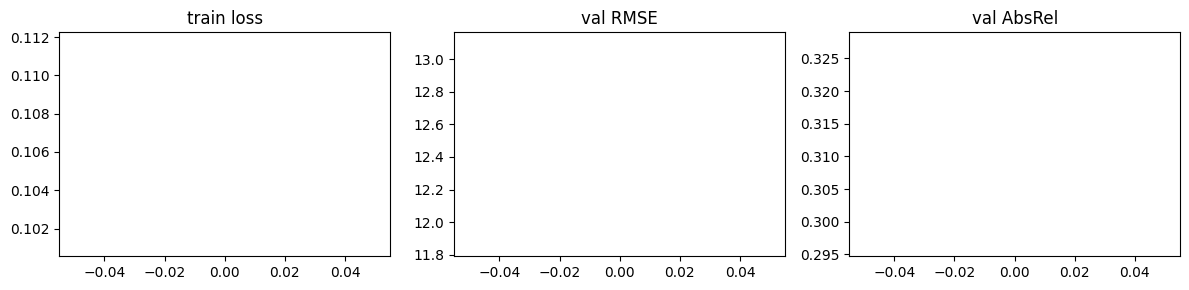

Epoch 1 done. train 0.1064 | val RMSE 12.477 AbsRel 0.312 | best RMSE 12.477


Epoch 2/50: 100%|██████████| 414/414 [03:51<00:00,  1.79it/s, loss=0.0616, lr=4.00e-04]


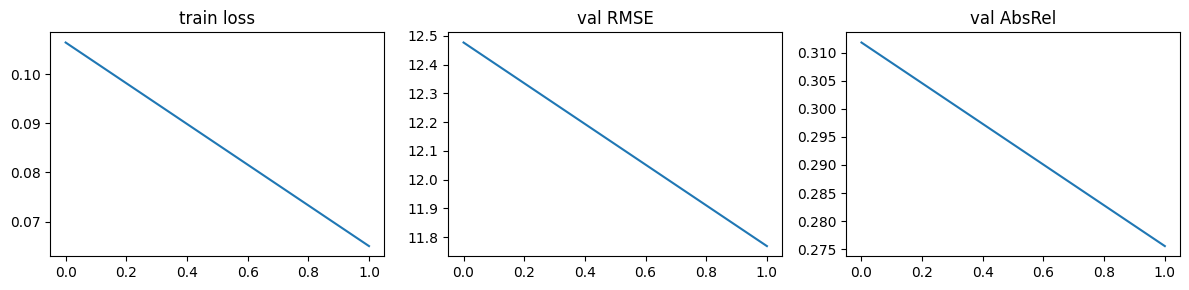

Epoch 2 done. train 0.0650 | val RMSE 11.769 AbsRel 0.276 | best RMSE 11.769


Epoch 3/50: 100%|██████████| 414/414 [05:07<00:00,  1.35it/s, loss=0.0549, lr=6.00e-04]


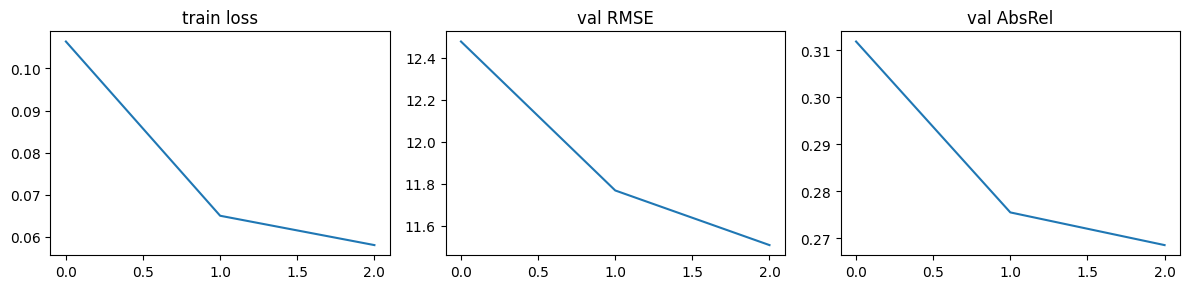

Epoch 3 done. train 0.0581 | val RMSE 11.509 AbsRel 0.269 | best RMSE 11.509


Epoch 4/50: 100%|██████████| 414/414 [04:46<00:00,  1.44it/s, loss=0.0423, lr=8.00e-04]


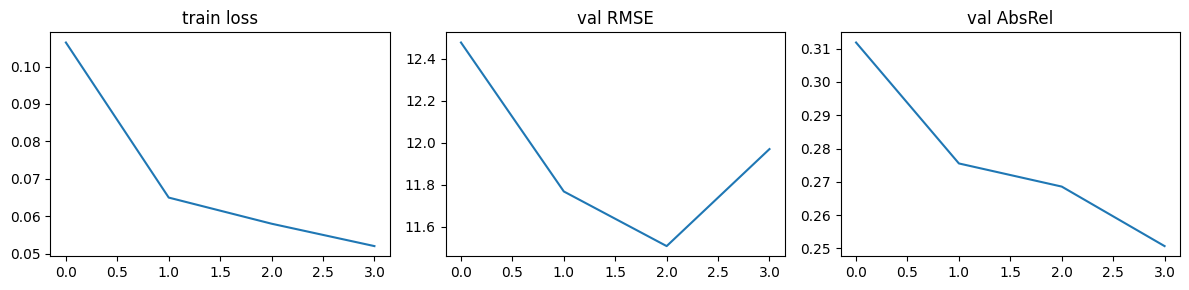

Epoch 4 done. train 0.0521 | val RMSE 11.970 AbsRel 0.251 | best RMSE 11.509


Epoch 5/50: 100%|██████████| 414/414 [03:37<00:00,  1.90it/s, loss=0.0532, lr=1.00e-03]


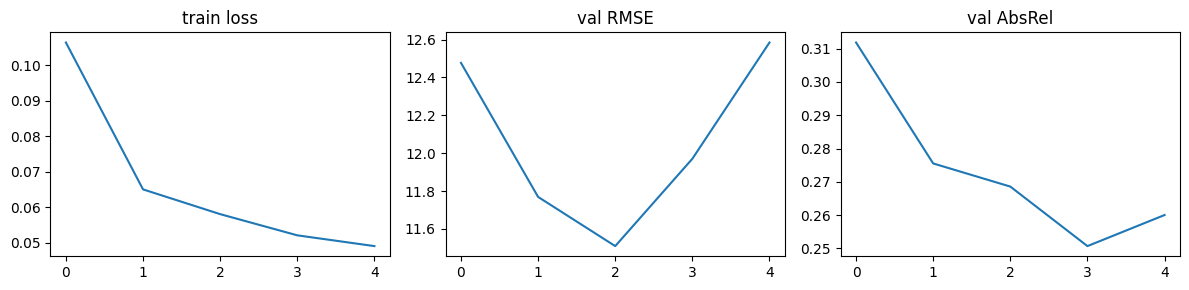

Epoch 5 done. train 0.0490 | val RMSE 12.585 AbsRel 0.260 | best RMSE 11.509


Epoch 6/50: 100%|██████████| 414/414 [03:37<00:00,  1.91it/s, loss=0.0367, lr=1.00e-03]


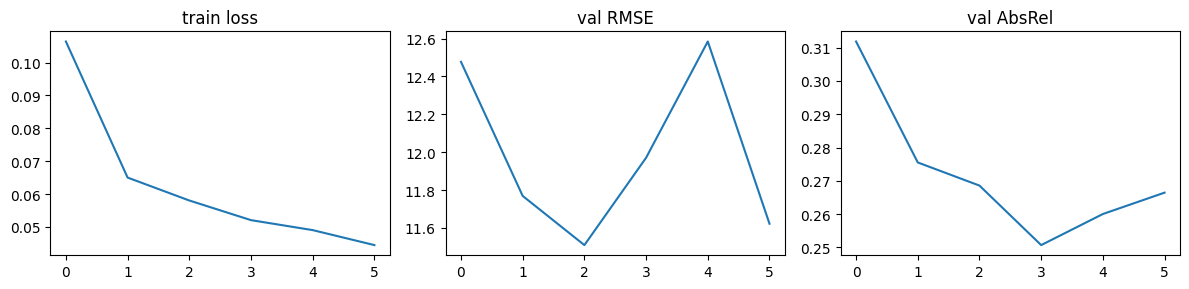

Epoch 6 done. train 0.0445 | val RMSE 11.622 AbsRel 0.266 | best RMSE 11.509


Epoch 7/50: 100%|██████████| 414/414 [03:36<00:00,  1.91it/s, loss=0.0544, lr=9.99e-04]


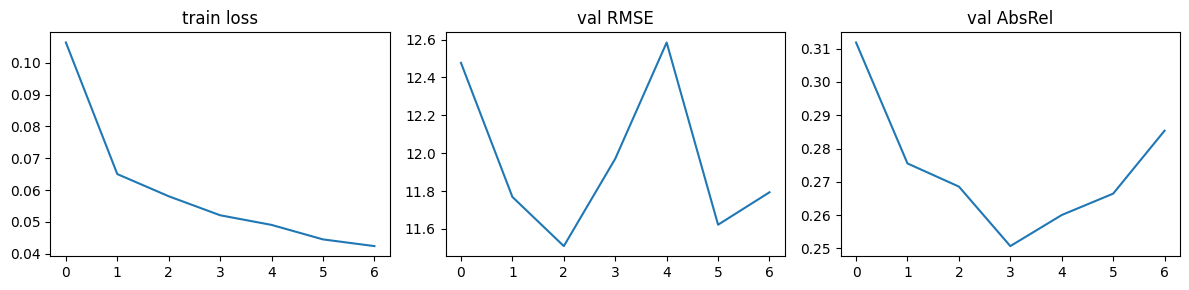

Epoch 7 done. train 0.0424 | val RMSE 11.793 AbsRel 0.285 | best RMSE 11.509


Epoch 8/50: 100%|██████████| 414/414 [03:36<00:00,  1.91it/s, loss=0.0403, lr=9.95e-04]


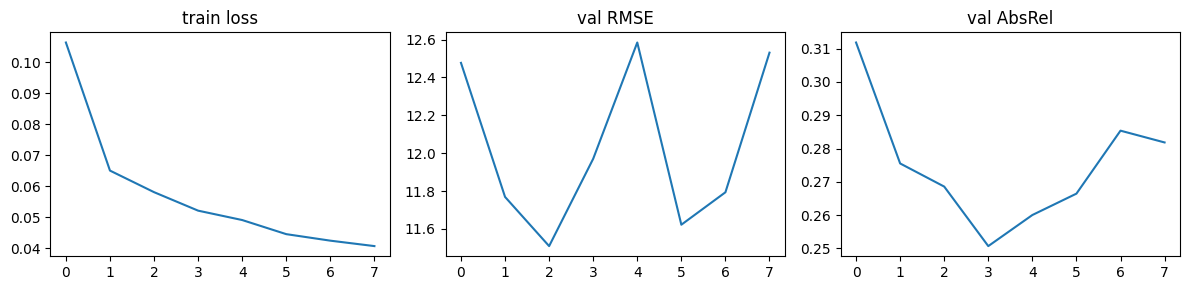

Epoch 8 done. train 0.0406 | val RMSE 12.531 AbsRel 0.282 | best RMSE 11.509


Epoch 9/50: 100%|██████████| 414/414 [03:36<00:00,  1.91it/s, loss=0.0362, lr=9.89e-04]


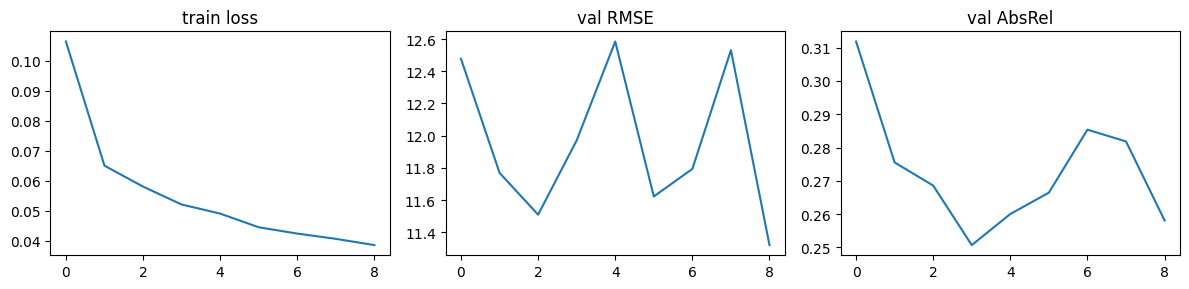

Epoch 9 done. train 0.0385 | val RMSE 11.320 AbsRel 0.258 | best RMSE 11.320


Epoch 10/50: 100%|██████████| 414/414 [03:36<00:00,  1.91it/s, loss=0.0369, lr=9.81e-04]


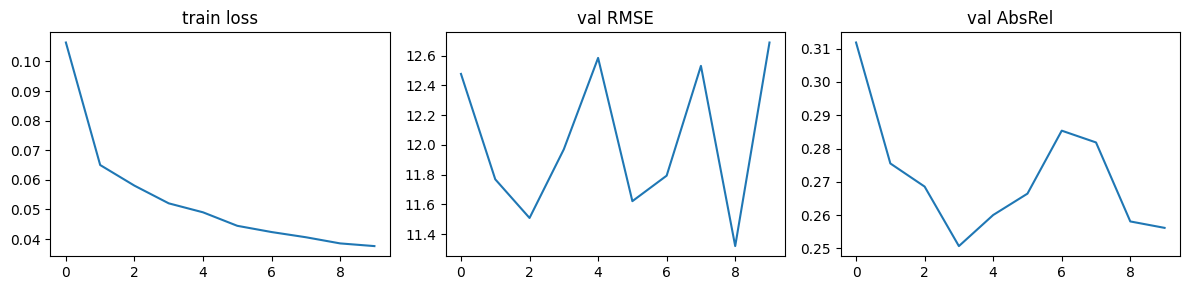

Epoch 10 done. train 0.0376 | val RMSE 12.688 AbsRel 0.256 | best RMSE 11.320


Epoch 11/50: 100%|██████████| 414/414 [03:37<00:00,  1.90it/s, loss=0.0429, lr=9.70e-04]


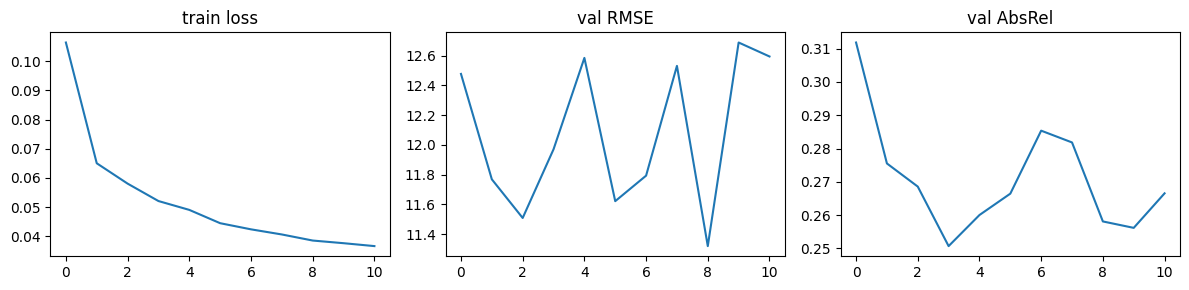

Epoch 11 done. train 0.0366 | val RMSE 12.595 AbsRel 0.267 | best RMSE 11.320


Epoch 12/50: 100%|██████████| 414/414 [03:37<00:00,  1.91it/s, loss=0.0349, lr=9.57e-04]


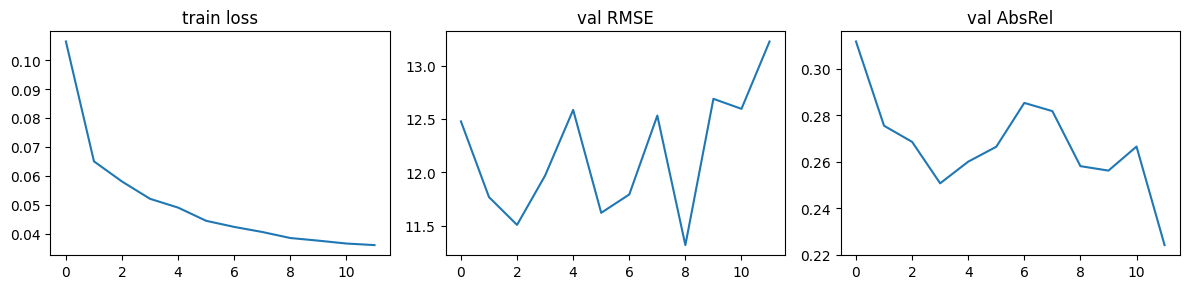

Epoch 12 done. train 0.0361 | val RMSE 13.225 AbsRel 0.224 | best RMSE 11.320


Epoch 13/50: 100%|██████████| 414/414 [03:41<00:00,  1.87it/s, loss=0.0416, lr=9.41e-04]


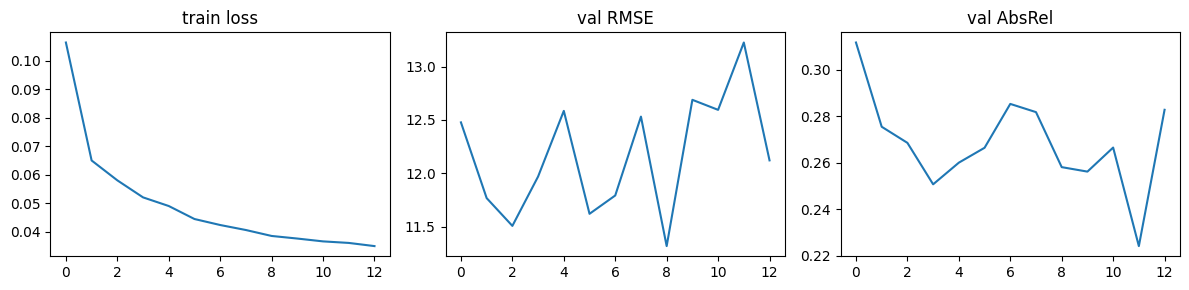

Epoch 13 done. train 0.0350 | val RMSE 12.122 AbsRel 0.283 | best RMSE 11.320


Epoch 14/50: 100%|██████████| 414/414 [03:37<00:00,  1.90it/s, loss=0.0324, lr=9.24e-04]


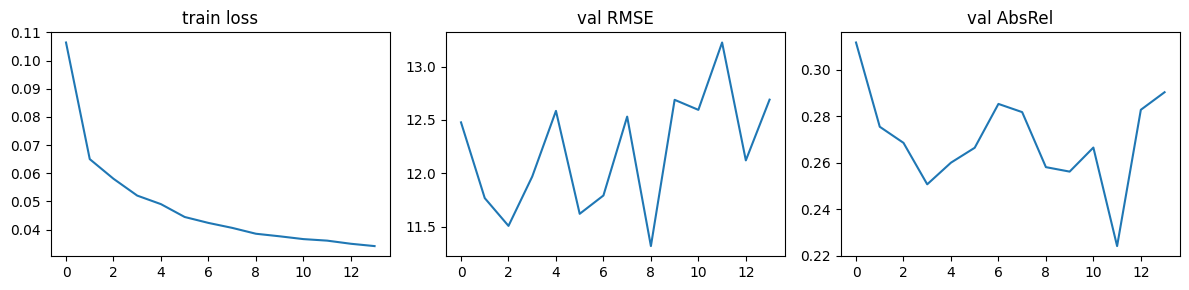

Epoch 14 done. train 0.0342 | val RMSE 12.690 AbsRel 0.290 | best RMSE 11.320


Epoch 15/50: 100%|██████████| 414/414 [03:37<00:00,  1.90it/s, loss=0.0365, lr=9.05e-04]


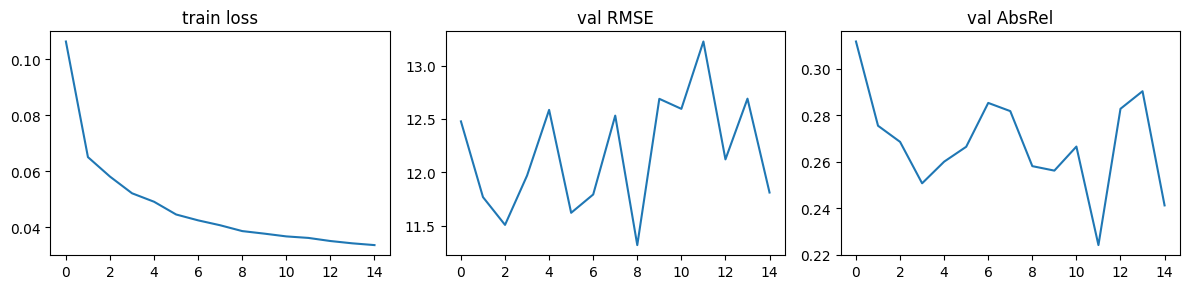

Epoch 15 done. train 0.0335 | val RMSE 11.812 AbsRel 0.241 | best RMSE 11.320


Epoch 16/50: 100%|██████████| 414/414 [03:39<00:00,  1.88it/s, loss=0.0312, lr=8.83e-04]


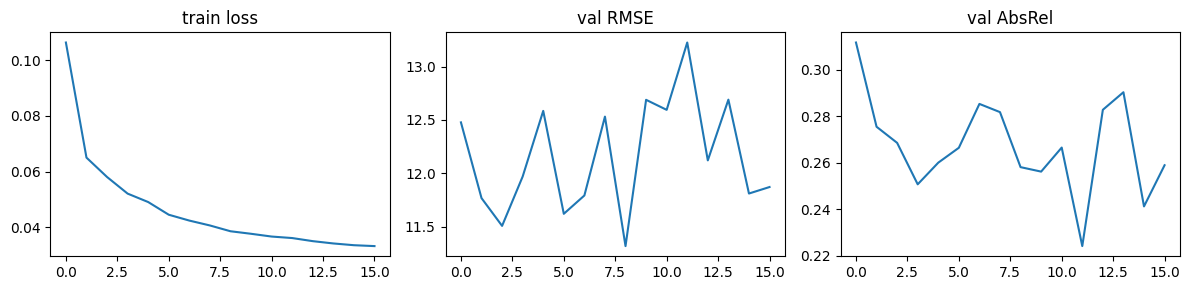

Epoch 16 done. train 0.0332 | val RMSE 11.872 AbsRel 0.259 | best RMSE 11.320


Epoch 17/50: 100%|██████████| 414/414 [03:42<00:00,  1.86it/s, loss=0.0287, lr=8.60e-04]


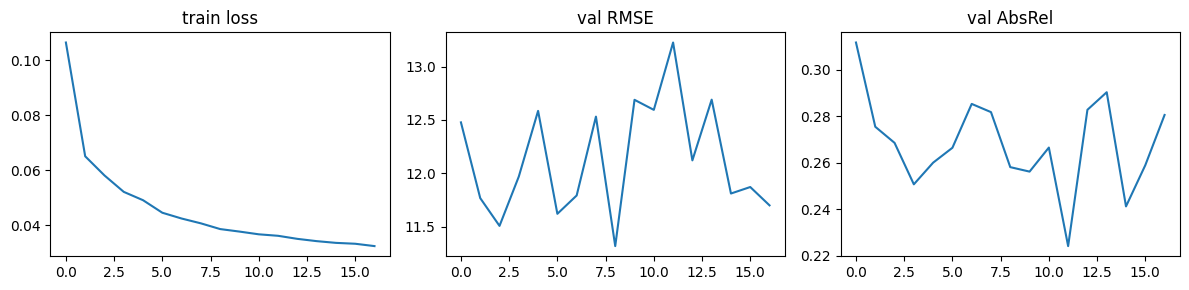

Epoch 17 done. train 0.0324 | val RMSE 11.701 AbsRel 0.281 | best RMSE 11.320


Epoch 18/50: 100%|██████████| 414/414 [03:42<00:00,  1.86it/s, loss=0.0335, lr=8.35e-04]


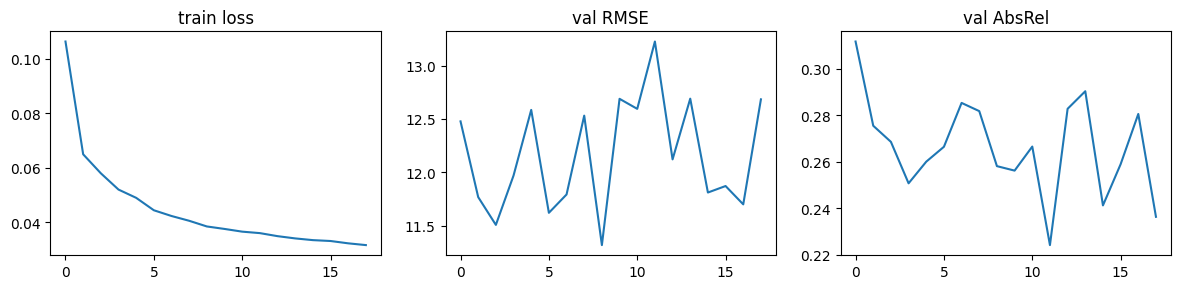

Epoch 18 done. train 0.0317 | val RMSE 12.683 AbsRel 0.236 | best RMSE 11.320


Epoch 19/50: 100%|██████████| 414/414 [03:42<00:00,  1.86it/s, loss=0.0288, lr=8.08e-04]


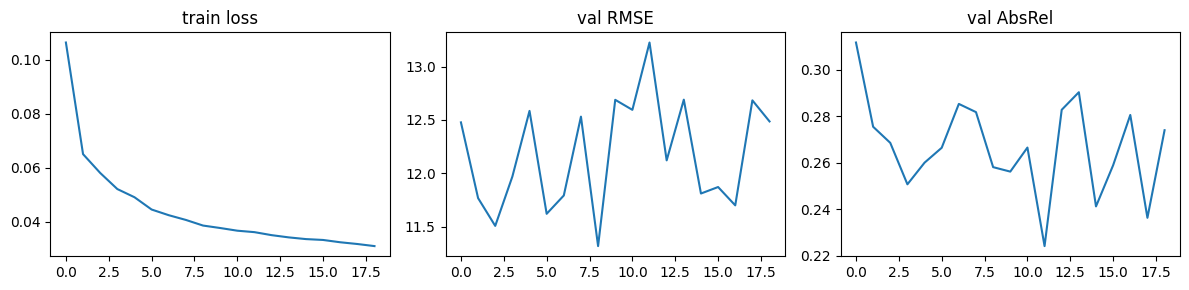

Epoch 19 done. train 0.0309 | val RMSE 12.486 AbsRel 0.274 | best RMSE 11.320


Epoch 20/50: 100%|██████████| 414/414 [03:43<00:00,  1.85it/s, loss=0.0310, lr=7.80e-04]


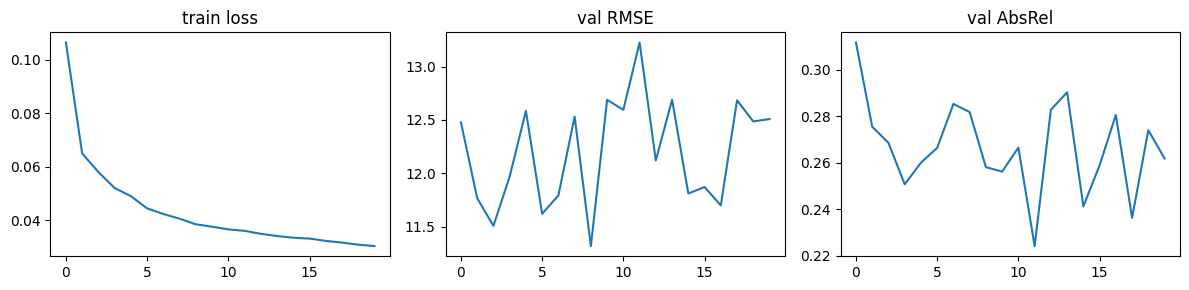

Epoch 20 done. train 0.0304 | val RMSE 12.508 AbsRel 0.262 | best RMSE 11.320


Epoch 21/50: 100%|██████████| 414/414 [03:42<00:00,  1.86it/s, loss=0.0307, lr=7.50e-04]


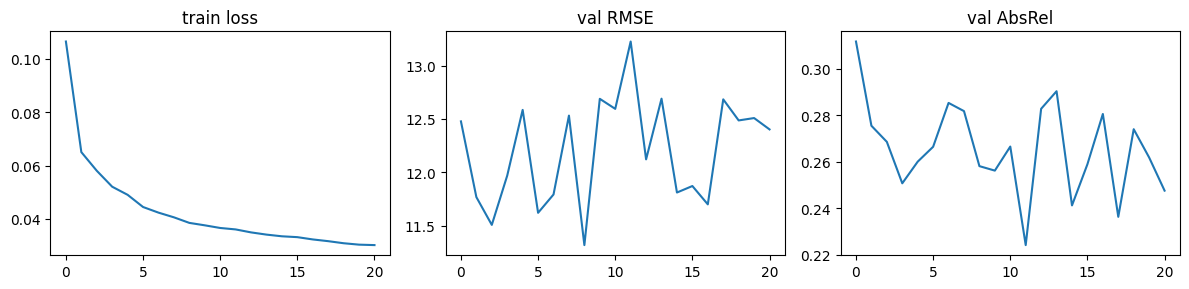

Epoch 21 done. train 0.0302 | val RMSE 12.402 AbsRel 0.248 | best RMSE 11.320


Epoch 22/50: 100%|██████████| 414/414 [03:41<00:00,  1.87it/s, loss=0.0261, lr=7.19e-04]


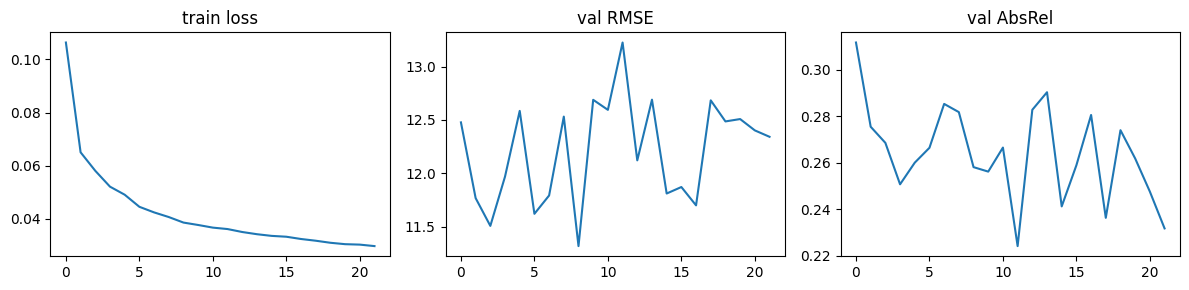

Epoch 22 done. train 0.0297 | val RMSE 12.342 AbsRel 0.232 | best RMSE 11.320


Epoch 23/50: 100%|██████████| 414/414 [03:42<00:00,  1.86it/s, loss=0.0287, lr=6.87e-04]


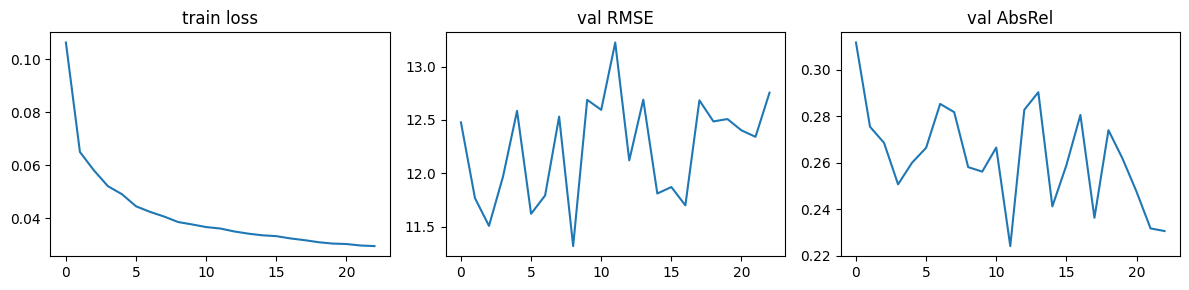

Epoch 23 done. train 0.0294 | val RMSE 12.755 AbsRel 0.231 | best RMSE 11.320


Epoch 24/50: 100%|██████████| 414/414 [03:42<00:00,  1.86it/s, loss=0.0248, lr=6.55e-04]


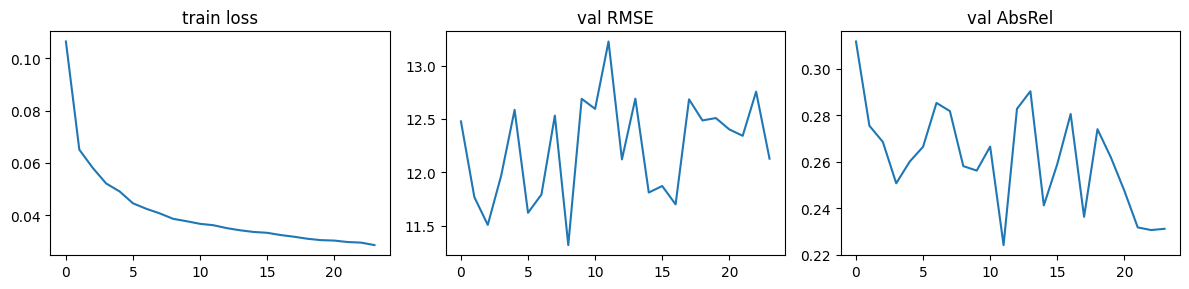

Epoch 24 done. train 0.0285 | val RMSE 12.128 AbsRel 0.231 | best RMSE 11.320


Epoch 25/50: 100%|██████████| 414/414 [03:41<00:00,  1.87it/s, loss=0.0269, lr=6.21e-04]


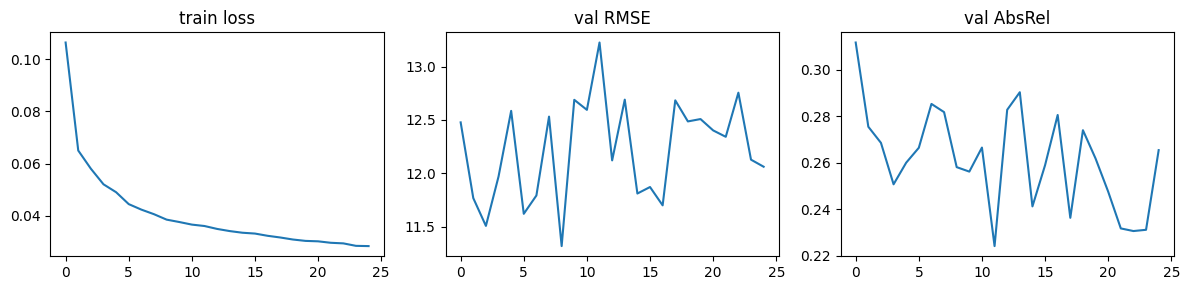

Epoch 25 done. train 0.0284 | val RMSE 12.062 AbsRel 0.265 | best RMSE 11.320


Epoch 26/50: 100%|██████████| 414/414 [03:41<00:00,  1.87it/s, loss=0.0320, lr=5.87e-04]


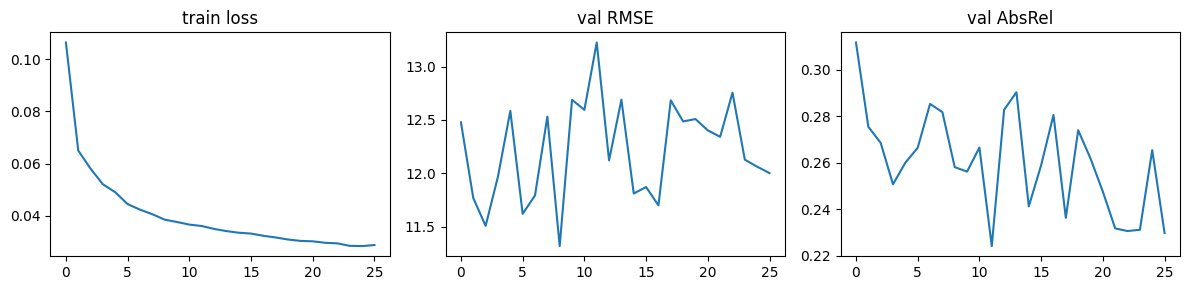

Epoch 26 done. train 0.0288 | val RMSE 12.003 AbsRel 0.230 | best RMSE 11.320


Epoch 27/50: 100%|██████████| 414/414 [03:41<00:00,  1.87it/s, loss=0.0221, lr=5.52e-04]


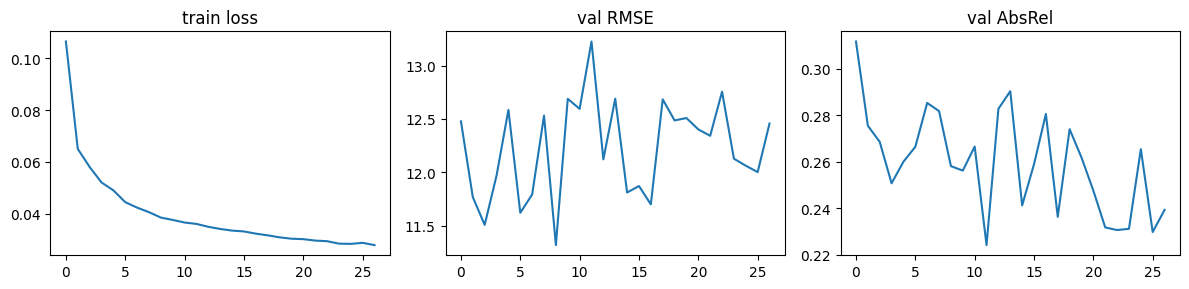

Epoch 27 done. train 0.0279 | val RMSE 12.457 AbsRel 0.239 | best RMSE 11.320


Epoch 28/50: 100%|██████████| 414/414 [03:41<00:00,  1.87it/s, loss=0.0310, lr=5.17e-04]


In [ ]:
# ===== Train with tqdm batch bar =====
from tqdm import tqdm
import platform

set_seed(42)

# Windows + Notebook 最穩：num_workers=0, pin_memory=False
num_workers = 0
pin_mem = False
if platform.system() == "Linux" and device.type == "cuda":
    # 你在 Linux server 可試著開高一點
    num_workers = 4
    pin_mem = True

train_set = ImageDepthNPY(config['train_images'], config['train_depths'], config['img_size'], config['max_depth'], aug=True)
val_set   = ImageDepthNPY(config['val_images'],   config['val_depths'],   config['img_size'], config['max_depth'], aug=False)

print("train samples:", len(train_set), "val samples:", len(val_set))

train_loader = DataLoader(
    train_set, batch_size=config['batch'], shuffle=True,
    num_workers=num_workers, pin_memory=pin_mem, drop_last=True
)
val_loader   = DataLoader(
    val_set, batch_size=config['batch'], shuffle=False,
    num_workers=num_workers, pin_memory=pin_mem
)
print("batches per epoch -> train:", len(train_loader), "val:", len(val_loader))

model = UNetSmall(in_ch=1).to(device)
loss_fn = DepthLoss(config['w_l1'], config['w_silog'])
opt = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

def lr_lambda(e):
    warm=max(3,int(0.1*config['epochs']))
    if e < warm: return (e+1)/warm
    prog=(e-warm)/max(1, config['epochs']-warm)
    return 0.5*(1+math.cos(math.pi*prog))
sch = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

outdir = Path(config['out_dir']); outdir.mkdir(parents=True, exist_ok=True)
best_rmse=float('inf')
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

hist = { 'train_loss': [], 'val_rmse': [], 'val_absrel': [] }

# 移除 clear_output 的干擾（先專心看進度）
fig,axs = plt.subplots(1,3, figsize=(12,3))
print(f"Device={device}; img_size={config['img_size']} batch={config['batch']}")

for epoch in range(config['epochs']):
    model.train()
    running = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}", leave=True)
    for i,(x,y,m) in enumerate(pbar):
        x,y,m = to_device((x,y,m), device)
        opt.zero_grad(set_to_none=True)
        with torch.autocast(device.type if device.type!='cpu' else 'cpu',
                            dtype=torch.float16 if device.type=='cuda' else torch.bfloat16,
                            enabled=(device.type!='cpu')):
            pred = model(x)
            loss = loss_fn(pred, y, m)
        scaler.scale(loss).backward()
        scaler.step(opt); scaler.update()
        running += loss.item() * x.size(0)

        # 在進度條上顯示目前 loss
        if (i+1) % 10 == 0:
            pbar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{sch.get_last_lr()[0]:.2e}")

    sch.step()
    tr_loss = running / len(train_loader.dataset)

    # 驗證
    val_rmse, val_absrel = evaluate(model, val_loader, device, config['max_depth'])
    hist['train_loss'].append(tr_loss); hist['val_rmse'].append(val_rmse); hist['val_absrel'].append(val_absrel)

    # 存 ckpt
    torch.save({'epoch': epoch, 'model': model.state_dict()}, outdir/'last.pt')
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        torch.save({'epoch': epoch, 'model': model.state_dict()}, outdir/'best.pt')

    # 畫曲線（不清空輸出）
    axs[0].cla(); axs[1].cla(); axs[2].cla()
    axs[0].plot(hist['train_loss']); axs[0].set_title('train loss')
    axs[1].plot(hist['val_rmse']);   axs[1].set_title('val RMSE')
    axs[2].plot(hist['val_absrel']); axs[2].set_title('val AbsRel')
    plt.tight_layout(); display(fig)

    print(f"Epoch {epoch+1} done. train {tr_loss:.4f} | val RMSE {val_rmse:.3f} AbsRel {val_absrel:.3f} | best RMSE {best_rmse:.3f}")

fig.savefig(outdir/'curves.png', dpi=150)
print("Training finished. Best RMSE =", best_rmse)


In [ ]:
# ===== Inference helpers =====
def load_ckpt(path, device):
    ck = torch.load(path, map_location=device)
    model = UNetSmall(in_ch=1).to(device)
    model.load_state_dict(ck['model']); model.eval(); return model

def infer_folder(model, in_images_dir, out_dir, img_size, max_depth, device):
    in_dir = Path(in_images_dir); out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    exts=(".png",".jpg",".jpeg",".bmp",".tif",".tiff",".webp")
    imgs = [p for p in in_dir.iterdir() if p.is_file() and p.suffix.lower() in exts]
    if not imgs: raise FileNotFoundError(f"No input images in {in_dir}")
    tf = T.Compose([T.Resize((img_size, img_size)), T.ToTensor(), T.Normalize(mean=(0.5,), std=(0.5,))])
    for p in imgs:
        pil = Image.open(p).convert('L'); W0,H0 = pil.size
        x = tf(pil).unsqueeze(0).to(device)
        with torch.autocast(device.type if device.type!='cpu' else 'cpu',
                            dtype=torch.float16 if device.type=='cuda' else torch.bfloat16,
                            enabled=(device.type!='cpu')):
            y = model(x)
        y = (y*max_depth).squeeze(0)
        y = F.interpolate(y.unsqueeze(0), size=(H0, W0), mode='bilinear', align_corners=False).squeeze(0)
        depth = y.squeeze(0).detach().cpu().numpy().astype(np.float32)
        np.save(out_dir/(p.stem+'.npy'), depth)
    print(f"Saved {len(imgs)} npy to {out_dir}")

# Example:
# model = load_ckpt(config['out_dir']+'/best.pt', device)
# infer_folder(model, 'path/to/new_images', 'out_npy', config['img_size'], config['max_depth'], device)
